# Imports

In [3]:
import pandas as pd
import numpy as np
import bz2
import json
import pickle
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from extraction_helpers import *
import os

In [4]:
# filename = open("extracted_data\output_2020 speakers_False keywords_['hurricane', 'climate change'].pickle", "rb")
# df = pickle.load(filename)

In [5]:
# Load pickle file

filename = os.listdir('./extracted_data')[0]
print("Considered file : " + "'" + filename +"'")

filename = open("extracted_data/{}".format(filename), "rb")
dict_df = pickle.load(filename)

Considered file : 'output_2019 speakers_False keywords_['hurricane', 'climate change'].pickle'



# Treat data

In [6]:
# In each date, remove the info about hours, minutes and seconds
# This facilitates aggregating data for each day

for keyword in dict_df:
    for index, row in dict_df[keyword].iterrows():
        dict_df[keyword]['date'][index] = pd.to_datetime(str(row['date'])[:10])


<ipython-input-6-908c623ac16b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_df[keyword]['date'][index] = pd.to_datetime(str(row['date'])[:10])


In [7]:
# Sort the values in ascending chronological order

for keyword in dict_df:
    dict_df[keyword] = dict_df[keyword].sort_values('date', ascending=True)


In [8]:
# Create a dictionary with the number of occurences of a keyword for each day of the year considered

dict_count_occurences = {}
for keyword in dict_df:
    dict_count_occurences[keyword] = dict_df[keyword]['date'].value_counts(sort=False)

In [9]:
for keyword in dict_count_occurences:
    print(dict_count_occurences[keyword].shape)

(358,)
(365,)


Some days have 0 occurences of a certain keyword, this might cause problems, we should fill these gaps

In [10]:
# Fill in the gaps so that the two dataframes have the same shape

for keyword in dict_count_occurences:
    for key in dict_count_occurences[keyword].keys():
        for keyword2 in dict_count_occurences:
            if key not in dict_count_occurences[keyword2].keys():
                dict_count_occurences[keyword2][key] = 0


# Sort in chronological order

for keyword in dict_count_occurences:
    dict_count_occurences[keyword].sort_index(inplace = True)

            

In [11]:


for keyword in dict_count_occurences:
    print(dict_count_occurences[keyword].shape)

(365,)
(365,)


They now have the same size !

# Plots

In [12]:
dict_count_occurences['hurricane']

2019-01-01     8
2019-01-02     4
2019-01-03    12
2019-01-04    11
2019-01-05     1
              ..
2019-12-27     3
2019-12-28     2
2019-12-29     2
2019-12-30     2
2019-12-31     2
Name: date, Length: 365, dtype: int64

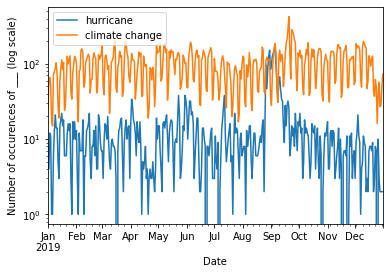

In [13]:
for keyword in dict_df:
    ax = dict_count_occurences[keyword].plot(logy = True)
ax.set_xlabel("Date")
ax.set_ylabel("Number of occurences of ___ (log scale)")
ax.legend([keyword for keyword in dict_df], loc = 'upper left')

We can see there is a correlation but it's drowned out by the periodic oscillations caused by the week-ends having less quotations.

Let's take a rolling average to smooth these plots

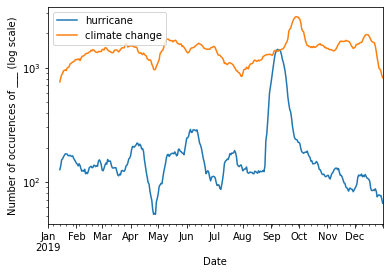

In [14]:
for keyword in dict_df:
    ax_roll = dict_count_occurences[keyword].rolling(14).sum().plot(logy = True)
ax_roll.set_xlabel("Date")
ax_roll.set_ylabel("Number of occurences of ___ (log scale)")
ax_roll.legend([keyword for keyword in dict_df], loc = 'upper left')

This shows very well there is a time-lagged correlation between the number of occurences of 'hurricane' in the quotes and the talk about climate change.

The period coincides with hurricane season in the United States.

Just to compare these plots even better, we can substract the average of each plot to compare the gap to the mean value. 

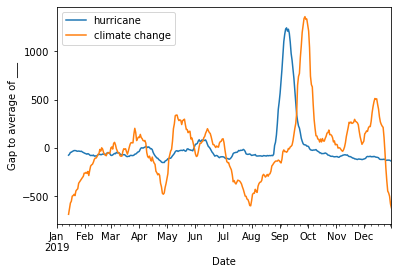

In [15]:
for keyword in dict_df:
    ax_roll = (dict_count_occurences[keyword].rolling(14).sum() - dict_count_occurences[keyword].rolling(14).sum().mean()).plot()
ax_roll.set_xlabel("Date")
ax_roll.set_ylabel("Gap to average of ___")
# ax_roll.set_ylim([300, 1500])
ax_roll.legend([keyword for keyword in dict_df], loc = 'upper left')

We can graphically see that there is correlation between the talk about natural disasters (at least hurricanes in this case) and the talk about climate change in the media. 

### EM-DAT dataset

Here we plot three different values for each storm which took place in 2019. These values are the storm speed, the number of people affected and the damage costs induced by the storm. Note that not every storm has a particular value for each attribute. By default such values are set to 0 during the data cleaning part (see emdat.ipynb). The point of these plots is to highlight how some features of a storm might be more correlated to the discussion around "hurricanes" (which is a type of storm) and "climate change" in general. When some storms have the same start date we take the mean of the corresponding attribute.

In [16]:
# Open processed EM-DAT dataset
df_emdat = pd.read_csv("data/emdat_processed.csv", index_col = "Dis No")

In [17]:
# View a sample of the data
df_emdat.head(2)

,Group,Subgroup,Type,Subtype,Subsubtype,Name,Country,ISO,Region,Continent,...,Scale,Deaths,Injured,Affected,Homeless,TotalAffected,Damages,StartDate,EndDate,Duration
Dis No,,,,,,,,,,,,,,,,,,,,,
2015-0011-MWI,Natural,Hydrological,Flood,Riverine flood,NaN,NaN,Malawi,MWI,Eastern Africa,Africa,...,Km2,278.0,645.0,638000.0,0.0,638645.0,390000.0,2015-01-01,2015-01-21,20
2015-0011-MOZ,Natural,Hydrological,Flood,Riverine flood,NaN,NaN,Mozambique,MOZ,Eastern Africa,Africa,...,Km2,160.0,0.0,177645.0,0.0,177645.0,0.0,2015-01-01,2015-02-09,39


In [18]:
# Create dataframe of only storms from 2019
# -- A hurricane is a type of storm --
mask = ((df_emdat['StartDate'] >= '2019-01-01') & (df_emdat['StartDate'] < '2020-01-01') & (df_emdat['Type'] == 'Storm'))
df_2019 = df_emdat.copy().loc[mask]

In [19]:
df_2019.set_index(['StartDate'],inplace=True)

In [20]:
# Some disasters have same StartDate so we group them together
grouped_2019 = df_2019.groupby(['StartDate'])

In [21]:
# For dates that overlap we take the mean of the desired attribute
grouped_magnitude = grouped_2019['Magnitude'].mean()
grouped_damages = grouped_2019['Damages'].mean()
grouped_affected = grouped_2019['Affected'].mean()

In [22]:
# Convert (string) dates to datetime dates for plotting
dates = [pd.to_datetime(d) for d in grouped_magnitude.index]
values_mag = grouped_magnitude.values

values_dam = grouped_damages.values

values_aff = grouped_affected.values

Here are the three resulting plots.

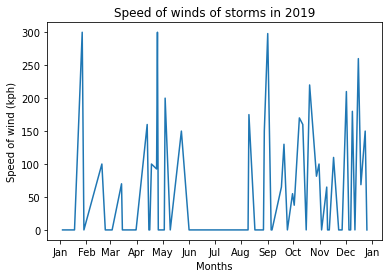

In [23]:
# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')

plt.xlabel('Months')
plt.ylabel('Speed of wind (kph)')
plt.title('Speed of winds of storms in 2019')
plt.plot(dates, values_mag)
X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)
plt.show()

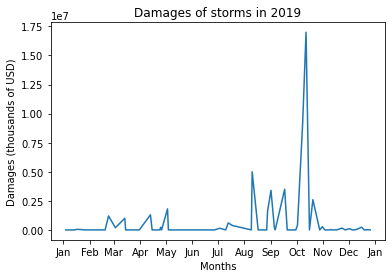

In [24]:
plt.xlabel('Months')
plt.ylabel('Damages (thousands of USD)')
plt.title('Damages of storms in 2019')
plt.plot(dates, values_dam)
X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)
plt.show()

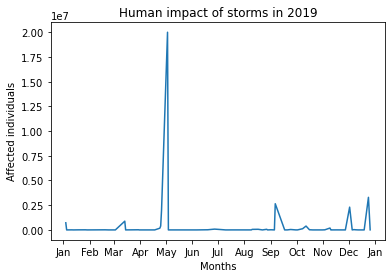

In [25]:
plt.xlabel('Months')
plt.ylabel('Affected individuals')
plt.title('Human impact of storms in 2019')
plt.plot(dates, values_aff)
X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)
plt.show()

If we display the same plot from the Quotebank dataset from 2019, we have:

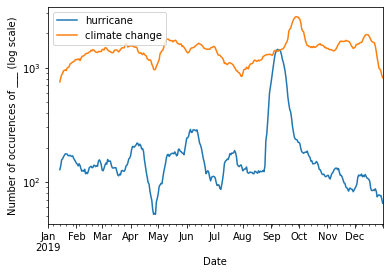

In [27]:
for keyword in dict_df:
    ax_roll = dict_count_occurences[keyword].rolling(14).sum().plot(logy = True)
ax_roll.set_xlabel("Date")
ax_roll.set_ylabel("Number of occurences of ___ (log scale)")
ax_roll.legend([keyword for keyword in dict_df], loc = 'upper left')

For example, we can see that there is a storm at the end of April that affected approximately 200 million people. This is linked with a strong increase in discussion around "hurricane" as well as an increase in discussion around "climate change". This might suggest that the number of affected people might be a better indicator of how much attention climate change gets compared to storm speeds or damages caused for the case of storms.

# Correlations

Let's see if we can show mathematically that a correlation exists between the mentions of 'hurricane' and the talk about cilmate change.

In [27]:
from statsmodels.tsa.stattools import ccf

In [28]:
hurr = dict_count_occurences['hurricane']
clim = dict_count_occurences['climate change']

Let's plot the cross correlation function of the two plots. 

<AxesSubplot:>

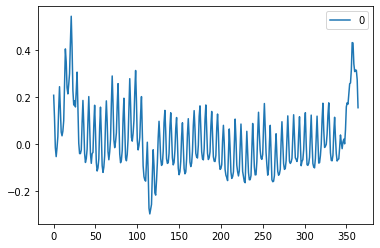

In [29]:
output_ccf = ccf(clim, hurr)
pd.DataFrame(output_ccf).plot()

We would prefer to get rid of these oscillations, we will calculate the ccf of the rolling average of the plots.

Text(20, 0    0.857116
dtype: float64, 'max : 0.71 for a shift of 20 days')

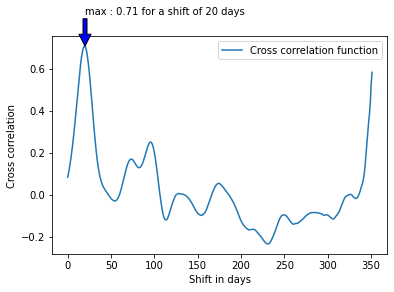

In [30]:
rolling = 14
hurr_r = dict_count_occurences['hurricane'].rolling(rolling).sum()[rolling-1:]
clim_r = dict_count_occurences['climate change'].rolling(rolling).sum()[rolling-1:]

output_ccf = pd.DataFrame(ccf(clim_r, hurr_r))
ax = output_ccf.plot()
ax.legend(['Cross correlation function'])
ax.set_xlabel("Shift in days")
ax.set_ylabel("Cross correlation")

ymax = output_ccf.max()
xpos = np.where(output_ccf == ymax)
xmax = xpos[0][0]

ax.annotate('max : {} for a shift of {} days'.format(round(float(ymax),2), xmax), xy=(xmax, ymax), \
    xytext=(xmax, ymax + 0.15), arrowprops=dict(facecolor='blue'),)


We can here see there is a clear time-lagged correlation. 

Talk about 'hurricanes' in the media could cause talk about climate change on average 20 days later.

We will investigate more in detail in the final milestone of this project.